<a href="https://colab.research.google.com/github/juseotin/Machine-Unlearning/blob/main/Group_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://unlearning-challenge.github.io/Unlearning-logo.png' width='100px'>

# NeurIPS 2023 Machine Unlearning Challenge Starting Kit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/unlearning-challenge/starting-kit/main/unlearning-CIFAR10.ipynb)


This notebook is part of the starting kit for the [NeurIPS 2023 Machine Unlearning Challenge](https://unlearning-challenge.github.io/). This notebook explains the pipeline of the challenge and contains sample unlearning and evaluation code.


This notebook has 3 sections:

  * 💾 In the first section we'll load a sample dataset (CIFAR10) and pre-trained model (ResNet18).

  * 🎯 In the second section we'll develop the unlearning algorithm. We start by splitting the original training set into a retain set and a forget set. The goal of an unlearning algorithm is to update the pre-trained model so that it approximates as much as possible a model that has been trained on the retain set but not on the forget set. We provide a simple unlearning algorithm as a starting point for participants to develop their own unlearning algorithms.

  * 🏅 In the third section we'll score our unlearning algorithm using a simple membership inference attacks (MIA). Note that this is a different evaluation than the one that will be used in the competition's submission.
  

We emphasize that this notebook is provided for convenience to help participants quickly get started. Submissions will be scored using a different method than the one provided in this notebook on a different (private) dataset of human faces. To run the notebook, the requirement is to have installed an up-to-date version of Python and Pytorch.

In [5]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


# 💾 Download dataset and pre-trained model

In this section, we'll load a sample dataset (CIFAR-10), a pre-trained model (ResNet18) trained on CIFAR-10, plot some images and compute the accuracy of the model on the test set.

In [6]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
# test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)

n = len(held_out)            # 10000 images in CIFAR10 test set
n_test = n // 2              # 5000
n_val = n - n_test           # 5000 (use remainder to avoid off-by-one)

test_set, val_set = torch.utils.data.random_split(
    held_out, [n_test, n_val], generator=RNG
)


test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

We'll now download the weights of the model trained in CIFAR-10 and load them in a Pytorch model. This model has been trained using SGD with a learning rate of 0.1, momentum of 0.9 and weight decay of 5e-4. It was also trained using data augmentation. In particular, the transforms used to the data were:

```python
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
```


In [7]:
# download pre-trained weights
local_path = "weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

Let us show some of the training images, just for fun.

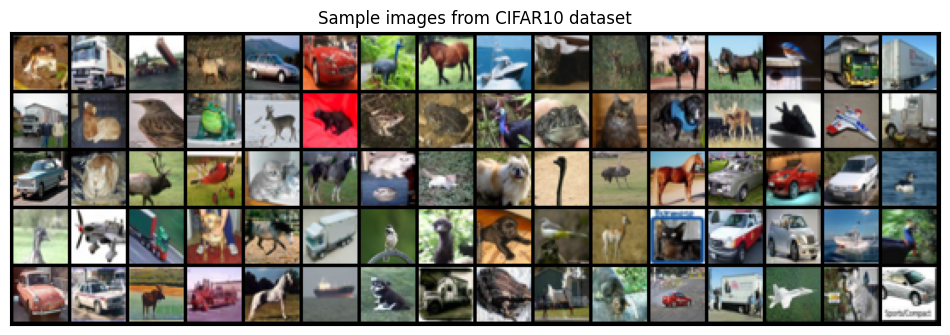

In [8]:
# a temporary data loader without normalization, just to show the images
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

## UNDIAL (added cell): Distillation-based unlearning with logit depression
This cell trains an **undial_student** starting from your pretrained weights, and keeps a frozen **teacher** snapshot for comparisons.


In [9]:
# === UNDIAL (revised; tuned + robust) ===
import copy, torch, torch.nn.functional as F
from torch import nn, optim
from itertools import cycle

# --- device / model ctor ---
if 'DEVICE' not in globals():
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
try:
    from torchvision.models import resnet18
except Exception:
    import torchvision.models as models
    resnet18 = lambda **kw: models.resnet18(**kw)

# --- build a fair starting point from baseline weights ---
base_student = resnet18(weights=None, num_classes=10).to(DEVICE)

def _load_state_safely(model, state):
    state = {k.replace("module.", ""): v for k, v in state.items()}
    missing, unexpected = model.load_state_dict(state, strict=False)
    if missing or unexpected:
        print("[UNDIAL] load_state_dict: missing:", missing, "unexpected:", unexpected)

if 'weights_pretrained' in globals() and isinstance(weights_pretrained, dict):
    _load_state_safely(base_student, weights_pretrained)
elif 'ft_model' in globals():
    _load_state_safely(base_student, ft_model.state_dict())
else:
    print("[UNDIAL] WARNING: no baseline weights found; training from scratch may be slow.")

assert 'retain_loader' in globals() and 'forget_loader' in globals(), "Need retain_loader & forget_loader"

# --- frozen teacher (pre-unlearning) ---
teacher = copy.deepcopy(base_student).to(DEVICE).eval()
for p in teacher.parameters(): p.requires_grad = False

# --- UNDIAL student ---
undial_student = copy.deepcopy(base_student).to(DEVICE)

# =================== hyperparameters ===================
EPOCHS          = 12      # 10–15 on Colab GPU
ALPHA           = 12.0    # logit depression (try 12–16 if forget is stubborn)
TEMP            = 4.0     # softer KD improves stability (2–4)
LAMBDA          = 1.0     # retain weight (0.8–1.2)
GAMMA           = 0.8     # entropy-to-uniform on forget (0–1)
WARMUP_EPOCHS   = 2       # use entropy-only for forget for first few epochs
FORGET_RATIO    = 2       # 2:1 forget:retain batches during warmup epochs
LR              = 0.1
WD              = 5e-4
MOM             = 0.9
CLIP_NORM       = 1.0     # gradient clipping
USE_AMP         = torch.cuda.is_available()

# =================== optim & sched ======================
opt   = optim.SGD(undial_student.parameters(), lr=LR, momentum=MOM, weight_decay=WD)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
ce    = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

# =================== training helpers ==================
@torch.no_grad()
def _acc(m, loader):
    m.eval(); c=t=0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        c += (m(xb).argmax(1) == yb).sum().item(); t += yb.numel()
    return c / max(1, t)

def _one_step(x_r, y_r, x_f, y_f, epoch_idx):
    undial_student.train()
    with torch.cuda.amp.autocast(enabled=USE_AMP):
        # teacher logits on forget + logit depression
        with torch.no_grad():
            z_t_f = teacher(x_f)
            z_adj = z_t_f.clone()
            idx = torch.arange(y_f.size(0), device=y_f.device)
            z_adj[idx, y_f] = z_adj[idx, y_f] - ALPHA
            p_adj = F.softmax(z_adj / TEMP, dim=-1)

        # student forward
        z_s_f = undial_student(x_f)
        z_s_r = undial_student(x_r)

        # forget loss: KL to adjusted teacher
        loss_forget = F.kl_div(
            F.log_softmax(z_s_f / TEMP, dim=-1),
            p_adj,
            reduction='batchmean'
        ) * (TEMP**2)

        # entropy warmup on forget (first few epochs)
        if epoch_idx < WARMUP_EPOCHS and GAMMA > 0:
            loss_entropy = GAMMA * F.kl_div(
                F.log_softmax(z_s_f, dim=-1),
                torch.full_like(z_s_f, 1.0 / z_s_f.size(1)),
                reduction='batchmean'
            )
            loss_forget = loss_forget + loss_entropy

        # retain utility: KD-to-teacher (gentler than CE)
        with torch.no_grad():
            z_t_r = teacher(x_r)
        loss_retain = LAMBDA * F.kl_div(
            F.log_softmax(z_s_r / TEMP, dim=-1),
            F.softmax(z_t_r / TEMP, dim=-1),
            reduction='batchmean'
        ) * (TEMP**2)

        loss = loss_forget + loss_retain

    opt.zero_grad()
    scaler.scale(loss).backward()
    if CLIP_NORM is not None:
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(undial_student.parameters(), CLIP_NORM)
    scaler.step(opt)
    scaler.update()
    return loss_forget.detach().item(), loss_retain.detach().item()

# =================== training loop =====================
undial_student.train()
for ep in range(EPOCHS):
    lf_sum = lr_sum = 0.0
    # warmup: do extra forget batches per retain batch
    steps = min(len(retain_loader), len(forget_loader))
    retain_iter = iter(retain_loader)
    forget_iter = iter(forget_loader)
    for _ in range(steps):
        try:
            x_r, y_r = next(retain_iter)
        except StopIteration:
            retain_iter = iter(retain_loader)
            x_r, y_r = next(retain_iter)
        try:
            x_f, y_f = next(forget_iter)
        except StopIteration:
            forget_iter = iter(forget_loader)
            x_f, y_f = next(forget_iter)

        x_r, y_r = x_r.to(DEVICE), y_r.to(DEVICE).long()
        x_f, y_f = x_f.to(DEVICE), y_f.to(DEVICE).long()

        # main balanced step
        lf, lr = _one_step(x_r, y_r, x_f, y_f, ep)
        lf_sum += lf; lr_sum += lr

        # extra forget-only steps during warmup (simulate ~2:1)
        if ep < WARMUP_EPOCHS:
            for _ in range(FORGET_RATIO - 1):
                try:
                    x_f2, y_f2 = next(forget_iter)
                except StopIteration:
                    forget_iter = iter(forget_loader)
                    x_f2, y_f2 = next(forget_iter)
                # reuse same retain batch (cheap) or use uniform retain (no-op)
                lf2, lr2 = _one_step(x_r, y_r, x_f2.to(DEVICE), y_f2.to(DEVICE).long(), ep)
                lf_sum += lf2; lr_sum += lr2

    sched.step()
    print(f"[UNDIAL] ep {ep+1}/{EPOCHS} "
          f"loss_f={lf_sum/steps:.3f} loss_r={lr_sum/steps:.3f} "
          f"acc_f={_acc(undial_student, forget_loader):.3f} acc_r={_acc(undial_student, retain_loader):.3f}")

undial_student.eval()
print("UNDIAL done — `teacher` (frozen) and `undial_student` (student) are ready.")


/tmp/ipython-input-3347403150.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
/tmp/ipython-input-3347403150.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


[UNDIAL] ep 1/12 loss_f=8.992 loss_r=8.767 acc_f=0.673 acc_r=0.780
[UNDIAL] ep 2/12 loss_f=6.799 loss_r=9.551 acc_f=0.595 acc_r=0.756
[UNDIAL] ep 3/12 loss_f=2.624 loss_r=3.555 acc_f=0.627 acc_r=0.828
[UNDIAL] ep 4/12 loss_f=2.466 loss_r=2.755 acc_f=0.579 acc_r=0.873
[UNDIAL] ep 5/12 loss_f=2.098 loss_r=2.338 acc_f=0.533 acc_r=0.878
[UNDIAL] ep 6/12 loss_f=1.597 loss_r=1.897 acc_f=0.546 acc_r=0.891
[UNDIAL] ep 7/12 loss_f=1.379 loss_r=1.517 acc_f=0.546 acc_r=0.915
[UNDIAL] ep 8/12 loss_f=1.201 loss_r=1.304 acc_f=0.544 acc_r=0.921
[UNDIAL] ep 9/12 loss_f=1.213 loss_r=1.151 acc_f=0.544 acc_r=0.932
[UNDIAL] ep 10/12 loss_f=1.106 loss_r=0.856 acc_f=0.546 acc_r=0.948
[UNDIAL] ep 11/12 loss_f=0.993 loss_r=0.788 acc_f=0.528 acc_r=0.951
[UNDIAL] ep 12/12 loss_f=0.969 loss_r=0.763 acc_f=0.527 acc_r=0.952
UNDIAL done — `teacher` (frozen) and `undial_student` (student) are ready.


## Metrics for UNDIAL
TR, KL/Margin (vs retrained-no-forget if available, else teacher), Predictive Agreement, and Influence (TracIn-style).

In [10]:

import torch, numpy as np, torch.nn.functional as F
from torch import autograd

DEVICE = next(undial_student.parameters()).device
ce = torch.nn.CrossEntropyLoss()

@torch.no_grad()
def avg_accuracy(model, loader):
    model.eval(); c=t=0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        c += (model(x).argmax(1)==y).sum().item(); t += y.numel()
    return c/max(1,t)

@torch.no_grad()
def avg_truth_ratio(model, loader):
    model.eval(); vals=[]
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        p = F.softmax(model(x), dim=-1)
        pt = p.gather(1, y.view(-1,1)).squeeze(1)
        pm = p.clone(); pm[torch.arange(len(y), device=y.device), y] = -1.0
        pn,_ = pm.max(1)
        vals.extend((pt/(pn+1e-12)).tolist())
    return float(np.mean(vals))

print("== Accuracy ==")
print("UNDIAL — forget:", avg_accuracy(undial_student, forget_loader))
print("UNDIAL — retain:", avg_accuracy(undial_student, retain_loader))

print("\\n== Truth Ratio ==")
print("TR — forget:", avg_truth_ratio(undial_student, forget_loader))
print("TR — retain:", avg_truth_ratio(undial_student, retain_loader))

# Reference model
ref = None
if 'ref_model' in globals():
    ref = ref_model.to(DEVICE).eval()
elif 'teacher' in globals():
    ref = teacher.to(DEVICE).eval()

@torch.no_grad()
def avg_kl_and_margin(model_a, model_b, loader, T=3.0):
    model_a.eval(); model_b.eval()
    kls, margins = [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        za = model_a(x); zb = model_b(x)
        pa_log = F.log_softmax(za / T, dim=-1)
        pb     = F.softmax(zb / T, dim=-1)
        kl = F.kl_div(pa_log, pb, reduction='batchmean') * (T**2)
        kls.append(kl.item())
        ya = za.gather(1, y.view(-1,1)).squeeze(1)
        max_other, _ = (za.masked_fill(F.one_hot(y, 10).bool(), float('-inf'))).max(1)
        margins.append((ya - max_other).mean().item())
    return float(np.mean(kls)), float(np.mean(margins))

if ref is not None:
    kl_f, m_f = avg_kl_and_margin(undial_student, ref, forget_loader, T=3.0)
    kl_r, m_r = avg_kl_and_margin(undial_student, ref, retain_loader, T=3.0)
    print("\\n== KL & Margin vs Ref ==")
    print(f"KL(Student||Ref) forget={kl_f:.4f}, margin={m_f:.4f}")
    print(f"KL(Student||Ref) retain={kl_r:.4f}, margin={m_r:.4f}")
else:
    print("\\n(No reference model available for KL/Margin)")

@torch.no_grad()
def predictive_agreement(model_a, model_b, loader):
    model_a.eval(); model_b.eval()
    agree, total = 0, 0
    for x, _ in loader:
        x = x.to(DEVICE)
        pa = model_a(x).argmax(1)
        pb = model_b(x).argmax(1)
        agree += (pa==pb).sum().item()
        total += pa.numel()
    return agree / max(1,total)

if ref is not None:
    pa_f = predictive_agreement(undial_student, ref, forget_loader)
    pa_r = predictive_agreement(undial_student, ref, retain_loader)
    print("\\n== Predictive Agreement (Student vs Ref) ==")
    print(f"PA — forget={pa_f:.3f} | retain={pa_r:.3f}")

# Influence
# ---------- Influence (TracIn-style) — FIXED ----------
def grad_vector(model, loss):
    grads = autograd.grad(loss, [p for p in model.parameters() if p.requires_grad],
                          retain_graph=False, create_graph=False)
    return torch.cat([g.contiguous().view(-1) for g in grads])

@torch.no_grad()
def sample_batch(loader, max_n=256):
    xs, ys, seen = [], [], 0
    for x, y in loader:
        xs.append(x); ys.append(y)
        seen += x.size(0)
        if seen >= max_n: break
    return torch.cat(xs,0), torch.cat(ys,0)

probe_x, probe_y = sample_batch(test_loader, 128)
forg_x, forg_y   = sample_batch(forget_loader, 256)
probe_x, probe_y = probe_x.to(DEVICE), probe_y.to(DEVICE)
forg_x, forg_y   = forg_x.to(DEVICE), forg_y.to(DEVICE)

def influence_score(model, X_train, Y_train, X_probe, Y_probe):
    model.zero_grad()
    model.train()
    logits_p = model(X_probe);  loss_p = ce(logits_p, Y_probe)
    g_probe  = grad_vector(model, loss_p)
    logits_t = model(X_train);  loss_t = ce(logits_t, Y_train)
    g_train  = grad_vector(model, loss_t)
    return torch.dot(g_probe, g_train).item()

# Student influence (student already requires grad)
with torch.enable_grad():
    influ_student = influence_score(undial_student, forg_x, forg_y, probe_x, probe_y)

# Teacher influence: temporarily enable grads
influ_teacher = None
if 'teacher' in globals():
    prev_flags = [p.requires_grad for p in teacher.parameters()]
    for p in teacher.parameters():
        p.requires_grad_(True)
    with torch.enable_grad():
        influ_teacher = influence_score(teacher, forg_x, forg_y, probe_x, probe_y)
    # restore original requires_grad flags
    for p, f in zip(teacher.parameters(), prev_flags):
        p.requires_grad_(f)

print("\n== Influence (forget→probe) ==")
if influ_teacher is not None:
    print(f"Before (teacher): {influ_teacher:.4e}")
print(f"After  (student): {influ_student:.4e}")
if influ_teacher is not None:
    print(f"Delta (student - teacher): {influ_student - influ_teacher:.4e}  (more negative ⇒ better)")



== Accuracy ==
UNDIAL — forget: 0.527
UNDIAL — retain: 0.9521333333333334
\n== Truth Ratio ==
TR — forget: 4.408912965636409
TR — retain: 34.814318172412996
\n== KL & Margin vs Ref ==
KL(Student||Ref) forget=6.7913, margin=-0.1503
KL(Student||Ref) retain=3.9451, margin=2.6225
\n== Predictive Agreement (Student vs Ref) ==
PA — forget=0.533 | retain=0.954

== Influence (forget→probe) ==
Before (teacher): 3.6004e-02
After  (student): -4.5776e-01
Delta (student - teacher): -4.9376e-01  (more negative ⇒ better)


We'll now compute the model's accuracy on the train and test set.


In [9]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 99.5%
Test set accuracy: 88.3%


In [ ]:
# model

In [ ]:


correct = 0
total = 0
for inputs, targets in train_loader:
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    outputs = model(inputs)
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
    break

In [ ]:
len(train_loader)

In [ ]:
train_loader

In [ ]:
targets.size(0)

# 🎯 Unlearning Algorithm

In this section we develop the unlearning algorithm.

In the previous section we created a split of the original training set into a retain set and a forget set. Typically, the retain set is much larger than the forget set. Here, we produce a split that is 10% forget set, and 90% retain set.

The goal of an unlearning algorithm is to produce a model that approximates as much as possible the model trained solely on the retain set.

Below is a simple unlearning algorithm provided for illustration purposes. We call this algorithm _unlearning by fine-tuning_. It starts from the pre-trained model and optimizes it for a few epochs on the retain set. This is a very simple unlearning algorithm, but it is not very computationally efficient, and we don't expect it to work very well for most metrics.

To make a new entry in the competition, participants will submit an unlearning function with the same API as the one below. Note that the unlearning function takes as input a pre-trained model, a retain set, a forget set and an evaluation set (even though the fine-tuning algorithm below only uses the retain set and ignores the other datasets).

In [ ]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

### RMU — Representation Matching Update (implementation)

Below we implement the RMU pseudocode from the attached image. The method operates on layer activations: it pushes the activations of *forgotten* samples towards a sampled random unit vector (scaled by `c`) while regularizing the updated model to stay close to a frozen model on retain samples.

Notes on this implementation:
- We use forward hooks to extract activations from a chosen layer (default: `avgpool` for ResNet18).
- For convolutional outputs (e.g., `avgpool`), activations are flattened per-sample before computing distances.
- The frozen model should be a copy of the original pre-trained model (kept in eval mode) — it provides the target activations for the retain set.
- The function trains `updated_model` to minimize L = L_forget + alpha * L_retain using SGD.

In [ ]:
import torch.nn as nn

def get_model_layers(model):
    """
    Recursively flattens a model into a list of (name, layer) tuples,
    filtering for specific types of layers that are suitable for
    sampling activations.

    This works for any model architecture, not just ResNet.
    """

    # --- Customize this list ---
    # Define the types of layers you want to be able to sample from.
    # These are typically the layers that produce the main representations.
    SAMPLABLE_LAYER_TYPES = (
        nn.Conv2d,
        nn.Linear
        # You could also add other types like:
        # nn.LSTM, nn.GRU,
        # nn.TransformerEncoderLayer,
        # nn.TransformerDecoderLayer,
    )

    samplable_layers = []

    # model.named_modules() recursively finds EVERY module in the network
    # (e.g., 'layer1.0.conv1', 'layer1.0.bn1', etc.)
    for name, module in model.named_modules():
        # We check if the module is an instance of any of the types
        # we defined in our tuple above.
        if isinstance(module, SAMPLABLE_LAYER_TYPES):
            samplable_layers.append((name, module))

    return samplable_layers

In [ ]:
def get_layer_range_indices(k, num_layers):
    """
    Returns the (start, end) indices for layer sampling based on k.
    """
    if k == 0.25:
        # First 25%
        start_idx = 0
        end_idx = int(num_layers * 0.25)-1
    elif k == 0.50:
        # 20% to 50% (as you specified)
        start_idx = int(num_layers * 0.25)
        end_idx = int(num_layers * 0.50)-1
    elif k == 0.75:
        # ASSUMPTION: 50% to 75%
        # print("Assuming k=0.75 samples from 50%-75% of layers.")
        start_idx = int(num_layers * 0.50)
        end_idx = int(num_layers * 0.75)-1
    elif k == 1.0:
        # ASSUMPTION: 75% to 100%
        # print("Assuming k=1.0 samples from 75%-100% of layers.")
        start_idx = int(num_layers * 0.75)
        end_idx = num_layers - 1 # Use -1 for zero-based index
    else:
        raise ValueError(f"Unknown k value: {k}")

    # Ensure end_idx is at least start_idx and within bounds
    end_idx = max(start_idx + 1, end_idx) # Ensure at least one layer
    end_idx = min(end_idx, num_layers - 1)

    return start_idx, end_idx

In [ ]:
def create_random_vectors(model_layers, device='cpu'):
    """
    Creates a dictionary of random unit vectors, one for each
    layer's activation. This is needed because each layer may
    have a different number of output channels.
    """
    u_vectors = {}
    for name, layer in model_layers:
        try:
            # Get output channels for Conv/Linear layers
            if hasattr(layer, 'out_channels'):
                channels = layer.out_channels
            elif hasattr(layer, 'out_features'):
                channels = layer.out_features
            # Handle ResNet blocks (use the output channels of the last conv)
            elif isinstance(layer, nn.Sequential):
                last_conv = [m for m in layer.modules() if isinstance(m, (nn.Conv2d, nn.Linear))][-1]
                channels = last_conv.out_channels if hasattr(last_conv, 'out_channels') else last_conv.out_features
            else:
                # Skip layers we can't get channels for
                continue

            # Create a random vector u
            u = torch.rand(channels, device=device)
            # Normalize to make it a unit vector
            u = u / torch.norm(u)

            # Reshape for broadcasting with (B, C, H, W) activations
            # New shape: (1, C, 1, 1)
            u_vectors[name] = u.view(1, -1, 1, 1)

        except Exception as e:
            print(f"Skipping layer {name}: {e}")

    return u_vectors

In [ ]:
get_layer_range_indices(1, 100)

In [ ]:
# ft_model = resnet18(weights=None, num_classes=10)
# ft_model.load_state_dict(weights_pretrained)
# ft_model.to(DEVICE)
# get_model_layers(ft_model)

In [ ]:
from rmu import train_rmu
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

finshied = train_rmu(ft_model, forget_loader, retain_loader, 0.25, epochs = 5, device = DEVICE)

In [ ]:
from truth_ratio import truth_ratio
truth_ratio(finshied, forget_loader)

In [ ]:

# --- 2. Your 'k' Parameter Logic ---
def get_layer_range_indices(k, num_layers):
    """
    Returns the (start, end) indices for layer sampling based on k.
    """
    if k == 0.25:
        # First 25%
        start_idx = 0
        end_idx = int(num_layers * 0.25)
    elif k == 0.50:
        # 20% to 50% (as you specified)
        start_idx = int(num_layers * 0.20)
        end_idx = int(num_layers * 0.50)
    elif k == 0.75:
        # ASSUMPTION: 50% to 75%
        print("Assuming k=0.75 samples from 50%-75% of layers.")
        start_idx = int(num_layers * 0.50)
        end_idx = int(num_layers * 0.75)
    elif k == 1.0 or k == 100:
        # ASSUMPTION: 75% to 100%
        print("Assuming k=1.0 samples from 75%-100% of layers.")
        start_idx = int(num_layers * 0.75)
        end_idx = num_layers - 1 # Use -1 for zero-based index
    else:
        raise ValueError(f"Unknown k value: {k}")

    # Ensure end_idx is at least start_idx and within bounds
    end_idx = max(start_idx + 1, end_idx) # Ensure at least one layer
    end_idx = min(end_idx, num_layers - 1)

    return start_idx, end_idx


# --- 3. Pre-computation of Random Vectors 'u' ---
def create_random_vectors(model_layers, device='cpu'):
    """
    Creates a dictionary of random unit vectors, one for each
    layer's activation. This is needed because each layer may
    have a different number of output channels.
    """
    u_vectors = {}
    for name, layer in model_layers:
        try:
            # Get output channels for Conv/Linear layers
            if hasattr(layer, 'out_channels'):
                channels = layer.out_channels
            elif hasattr(layer, 'out_features'):
                channels = layer.out_features
            # Handle ResNet blocks (use the output channels of the last conv)
            elif isinstance(layer, nn.Sequential):
                last_conv = [m for m in layer.modules() if isinstance(m, (nn.Conv2d, nn.Linear))][-1]
                channels = last_conv.out_channels if hasattr(last_conv, 'out_channels') else last_conv.out_features
            else:
                # Skip layers we can't get channels for
                continue

            # Create a random vector u
            u = torch.rand(channels, device=device)
            # Normalize to make it a unit vector
            u = u / torch.norm(u)

            # Reshape for broadcasting with (B, C, H, W) activations
            # New shape: (1, C, 1, 1)
            u_vectors[name] = u.view(1, -1, 1, 1)

        except Exception as e:
            print(f"Skipping layer {name}: {e}")

    return u_vectors


# --- 4. The Main Training/Unlearning Function ---
def train_rmu(model, forget_loader, retain_loader, k, epochs=1, lr=1e-5, c=6.5, alpha=1200, device='cpu'):

    model.to(device)
    model.train()

    # 1. Create the frozen model
    model_frozen = copy.deepcopy(model)
    model_frozen.eval()
    for param in model_frozen.parameters():
        param.requires_grad = False

    # 2. Setup optimizer (only for the updated model)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 3. Get the list of layers to sample from
    model_layers = get_model_layers(model)
    layer_names = [name for name, _ in model_layers]
    num_layers = len(layer_names)

    # 4. Create the dictionary of random 'u' vectors
    u_vectors = create_random_vectors(model_layers, device=device)

    # Store activations from the hook
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output
        return hook

    # --- Training Loop ---
    for epoch in range(epochs):
        # We need data from both loaders in each step
        for (forget_data, _) , (retain_data, _) in zip(forget_loader, retain_loader):
            forget_data = forget_data.to(device)
            retain_data = retain_data.to(device)

            # 5. Sample a layer based on k
            start_idx, end_idx = get_layer_range_indices(k, num_layers)

            if start_idx >= end_idx:
                print(f"Warning: Invalid layer range for k={k}. Skipping batch.")
                continue

            sampled_idx = random.randint(start_idx, end_idx)
            sampled_layer_name = layer_names[sampled_idx]

            if sampled_layer_name not in u_vectors:
                print(f"Warning: Layer {sampled_layer_name} has no 'u' vector. Skipping.")
                continue

            # 6. Get the 'u' vector for the sampled layer
            u = u_vectors[sampled_layer_name].to(device)

            # 7. Register hooks on both models at the *same* layer
            # Using dict.get() to find the module in the model
            hook_handle_updated = model.get_submodule(sampled_layer_name).register_forward_hook(get_activation("updated"))
            hook_handle_frozen = model_frozen.get_submodule(sampled_layer_name).register_forward_hook(get_activation("frozen"))

            # --- 8. Calculate Forget Loss ---
            optimizer.zero_grad()

            # Forward pass for forget data
            _ = model(forget_data)
            act_forget = activations["updated"] # Get activation from hook

            # Handle FC layer (B, C) vs Conv layer (B, C, H, W)
            if act_forget.dim() == 2: # (Batch, Features)
                u = u.view(1, -1) # Reshape u to (1, Features)

            # L_forget = || M_updated(x_f) - c*u ||^2
            loss_forget = torch.mean((act_forget - c * u)**2)

            # --- 9. Calculate Retain Loss ---

            # Forward pass for retain data on both models
            _ = model(retain_data)
            act_retain_updated = activations["updated"] # Get activation

            _ = model_frozen(retain_data)
            act_retain_frozen = activations["frozen"] # Get activation

            # L_retain = || M_updated(x_r) - M_frozen(x_r) ||^2
            loss_retain = torch.mean((act_retain_updated - act_retain_frozen)**2)

            # --- 10. Total Loss and Backpropagation ---

            # L = L_forget + alpha * L_retain
            loss = loss_forget + alpha * loss_retain

            loss.backward()
            optimizer.step()

            # 11. IMPORTANT: Remove hooks after use
            hook_handle_updated.remove()
            hook_handle_frozen.remove()
            activations = {} # Clear for next batch

            print(f"Epoch {epoch}, Layer: {sampled_layer_name}, Loss: {loss.item():.4f}, Forget: {loss_forget.item():.4f}, Retain: {loss_retain.item():.4f}")

In [ ]:
import math
from collections import OrderedDict

def _get_module_by_name(model, name):
    """Return module in model with given dotted name."""
    modules = dict(model.named_modules())
    if name in modules:
        return modules[name]
    raise KeyError(f'No module named {name} in model')

def rmu_unlearning(updated_model, frozen_model, retain_loader, forget_loader,
                  layer_name='avgpool', c=1.0, alpha=1.0, epochs=1, lr=1e-2, device=DEVICE,
                  optimizer_cls=torch.optim.SGD, optimizer_kwargs=None, print_every=100):
    """Perform RMU-style unlearning on `updated_model`.

    Args:
      updated_model: nn.Module to be updated (will be trained).
      frozen_model: nn.Module kept frozen (provides targets for retain set).
      retain_loader, forget_loader: DataLoaders for retain and forget sets.
      layer_name: name of the module whose activations are used (e.g., 'avgpool').
      c: scalar multiplier for the random unit vector target for forget activations.
      alpha: weight for the retain loss.
      epochs, lr: training hyperparameters.
      device: device string or torch.device.
      optimizer_cls, optimizer_kwargs: optimizer and kwargs for updated_model.
      print_every: how often to print progress (batches).

    Returns:
      updated_model (same object, updated in-place).
    """
    if optimizer_kwargs is None:
        optimizer_kwargs = dict(lr=lr, momentum=0.9, weight_decay=5e-4)

    # prepare hooks to capture activations
    updated_acts = {}
    frozen_acts = {}

    def make_hook(store, key):
        def hook(module, inp, out):
            # store a detached reference for frozen, but keep grad graph for updated
            store[key] = out
        return hook

    # find modules by name and register hooks
    upd_mod = _get_module_by_name(updated_model, layer_name)
    frz_mod = _get_module_by_name(frozen_model, layer_name)

    h_upd = upd_mod.register_forward_hook(make_hook(updated_acts, 'act'))
    h_frz = frz_mod.register_forward_hook(make_hook(frozen_acts, 'act'))

    # optimizer for updated_model
    optimizer = optimizer_cls(updated_model.parameters(), **optimizer_kwargs)
    criterion = torch.nn.MSELoss(reduction='mean')

    # sample random unit vector u once (we will lazily create after we know dim)
    u = None

    # zip through both loaders; zip stops at the shorter loader length
    for epoch in range(epochs):
        updated_model.train()
        frozen_model.eval()
        batch_i = 0
        for (f_inputs, _), (r_inputs, _) in zip(forget_loader, retain_loader):
            f_inputs = f_inputs.to(device)
            r_inputs = r_inputs.to(device)

            # get frozen activations for retain inputs (no grad)
            with torch.no_grad():
                _ = frozen_model(r_inputs)
                frz_act = frozen_acts['act']
                # ensure tensor detached
                frz_act = frz_act.detach()

            # forward through updated_model to get activations for forget and retain (these should track grads)
            upd_out_f = updated_model(f_inputs)
            act_f = updated_acts['act']
            upd_out_r = updated_model(r_inputs)
            act_r = updated_acts['act']

            # flatten activations per-sample to shape [batch, D]
            def _flatten_act(t):
                if t.dim() > 2:
                    return t.view(t.size(0), -1)
                return t

            act_f_flat = _flatten_act(act_f)
            act_r_flat = _flatten_act(act_r)
            frz_act_flat = _flatten_act(frz_act)

            # lazily create random unit vector u of same dimension
            if u is None:
                dim = act_f_flat.size(1)
                # sample uniform(0,1) entries then normalize to unit length
                u_t = torch.rand(dim, device=device)
                u_t = u_t / (u_t.norm() + 1e-12)
                u = (c * u_t).view(1, -1)  # shape [1, dim], will broadcast to batch

            # compute losses: mean squared distance
            target_forget = u.expand(act_f_flat.size(0), -1)
            L_forget = criterion(act_f_flat, target_forget)

            # retain loss: keep updated_model close to frozen_model on retain set
            # ensure shapes match; frz is detached
            if act_r_flat.size() != frz_act_flat.size():
                raise RuntimeError(f'Activation shape mismatch: {act_r_flat.size()} vs {frz_act_flat.size()}')
            L_retain = criterion(act_r_flat, frz_act_flat)

            loss = L_forget + alpha * L_retain

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_i + 1) % print_every == 0:
                print(f'Epoch {epoch+1} batch {batch_i+1}: loss={loss.item():.6f} (L_forget={L_forget.item():.6f}, L_retain={L_retain.item():.6f})')
            batch_i += 1

    # remove hooks
    h_upd.remove()
    h_frz.remove()

    return updated_model

#### Usage example (lightweight)

Below is an example of how to call `rmu_unlearning`. Running this for many epochs on the full dataset may be slow; the example uses small epoch and default hyperparameters for demonstration.

In [ ]:
# create a fresh copy of the pretrained weights for the updated model
rmu_model = resnet18(weights=None, num_classes=10)
rmu_model.load_state_dict(weights_pretrained)
rmu_model.to(DEVICE)

# frozen_model: keep a copy of the original pretrained model (no grads)
frozen_model = resnet18(weights=None, num_classes=10)
frozen_model.load_state_dict(weights_pretrained)
frozen_model.to(DEVICE)
frozen_model.eval()

# Run RMU for 1 epoch with small learning rate as a demo (this will update rmu_model in-place).
# Note: this may still take time depending on your hardware.
rmu_model = rmu_unlearning(rmu_model, frozen_model, retain_loader, forget_loader, layer_name='avgpool', c=1.0, alpha=1.0, epochs=1, lr=1e-2, device=DEVICE, print_every=50)

# After running, evaluate the RMU-updated model similar to earlier:
print(f'Retain set accuracy (RMU): {100.0 * accuracy(rmu_model, retain_loader):0.1f}%')
print(f'Test set accuracy (RMU): {100.0 * accuracy(rmu_model, test_loader):0.1f}%')

In [ ]:
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
ft_model = unlearning(ft_model, retain_loader, forget_loader, test_loader)

In [ ]:
# for i, t in forget_loader:
#     print(i)
#     print(t)
#     break

We have now an unlearned model `ft_model`. Besides the forgetting quality (which we'll discuss in the next section), a good unlearning algorithm should retain as much as possible the accuracy on the retain and test set.

To quantify this potential loss of utility, we'll now compute the retain and test accuracies using the unlearned model

In [ ]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")

# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [ ]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        # losses = criterion(logits, targets).numpy(force=True)
        losses = criterion(logits, targets).detach().cpu().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

In [ ]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

As per the above plot, the distributions of losses are quite different between the train and test sets, as expected. In what follows, we will define an MIA that leverages the fact that examples that were trained on have smaller losses compared to examples that weren't. Using this fact, the simple MIA defined below will aim to infer whether the forget set was in fact part of the training set.

This MIA is defined below. It takes as input the per-sample losses of the unlearned model on forget and test examples, and a membership label (0 or 1) indicating which of those two groups each sample comes from. It then returns the cross-validation accuracy of a linear model trained to distinguish between the two classes.

Intuitively, an unlearning algorithm is successful with respect to this simple metric if the attacker isn't able to distinguish the forget set from the test set any better than it would for the ideal unlearning algorithm (retraining from scratch without the retain set); see the last section of this notebook for additional discussion and for computing that reference point.

In [ ]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [ ]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [ ]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [ ]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

One might ask, how good are the scores above? What is the best score? Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

We'll now compute this score. We'll first download the weights for a model trained exclusively on the retain set and then compute the accuracy of the simple MIA.

In [ ]:
# download weights of a model trained exclusively on the retain set
local_path = "retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set (whose accuracy is similar than on the test set)

In [ ]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [ ]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

As we expect, the accuracy of the MIA attack is roughly 0.5. Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## 📏 Truth-ratio metrics

We'll compute a few
 style metrics that measure how closely the unlearned model (`ft_model`) matches the model retrained from scratch on the retain set (`rt_model`).
These metrics are useful to quantify *how much* the unlearned model's behavior aligns with the ideal retrained model (the 'truth') instead of the original pre-trained model.

We implement:
- Prediction-level truth ratio (top-1): fraction of samples where models agree on the top predicted class.
- Top-k truth ratio: fraction where retrain's top-1 is inside the other model's top-k predictions.
- Probability agreement (cosine similarity): average cosine similarity between softmax probability vectors.

We'll compute these metrics on the forget set (primary interest) and also on the test set (as a baseline).

In [ ]:
import torch
import numpy as np

# Assume DEVICE is defined (e.g., DEVICE = 'cuda' or 'cpu')
# Assume model, ft_model, rt_model, forget_loader, and test_loader are defined

def compute_all_outputs(net, loader):
    """
    Return (probs, labels, preds) for all samples in loader.
    Note: This function now *requires* the loader to return (inputs, labels).
    """
    net.eval()
    all_probs = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            logits = net(inputs)
            p = torch.softmax(logits, dim=1)

            all_probs.append(p.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_preds.append(logits.argmax(1).cpu().numpy())

    return np.concatenate(all_probs), np.concatenate(all_labels), np.concatenate(all_preds)

def compute_classification_truth_ratio(probs, labels):
    """
    Computes the ratio of P(true_label) / (P(true_label) + P(highest_wrong_label)).

    A value of 1.0 means high confidence in the true label.
    A value of 0.5 means the model is equally confident in the true label
    and the next-best-wrong label (i.e., it has forgotten).
    """
    # p_para: Get the probability of the *true label* for each sample
    # probs shape is (n_samples, n_classes), labels shape is (n_samples,)
    p_para = probs[np.arange(len(labels)), labels]

    # p_pert: Get the probability of the *highest-scoring wrong label*
    # We copy the probs, set the true label's prob to -1, and then find the max
    probs_copy = probs.copy()
    probs_copy[np.arange(len(labels)), labels] = -1.0
    p_pert = probs_copy.max(axis=1)

    # Compute the ratio, add epsilon for numerical stability
    ratio = p_para / (p_para + p_pert + 1e-12)
    return ratio.mean()
# --- Main Evaluation Script ---

# 1. Compute outputs for all models on the FORGET set
# We only need the labels from one loader, as they are identical.
orig_forget_probs, forget_labels, _ = compute_all_outputs(model, forget_loader)
ft_forget_probs, ft_, _ = compute_all_outputs(ft_model, forget_loader)
rt_forget_probs,rt_, _ = compute_all_outputs(rt_model, forget_loader)


# --- Metrics on FORGET set (Primary Unlearning Goal) ---
print('--- Metrics on FORGET set ---')
print('\nTarget for unlearning is 0.5 (random chance between true and wrong)')
print('--- Classification Truth Ratio (True vs. Highest Wrong) ---')
print(f'Original Model: {compute_classification_truth_ratio(orig_forget_probs, forget_labels):.4f}')
print(f'Unlearned Model (ft): {compute_classification_truth_ratio(ft_forget_probs, ft_):.4f}')
print(f'Retrained Model (rt): {compute_classification_truth_ratio(rt_forget_probs, rt_):.4f}')


# --- Metrics on TEST set (Model Utility / Sanity Check) ---
print('\n--- Metrics on TEST set (Utility) ---')
print('Target is high (all models should still perform well)')
print('--- Classification Truth Ratio (True vs. Highest Wrong) ---')
print(f'Original Model: {compute_classification_truth_ratio(orig_test_probs, test_labels):.4f}')
print(f'Unlearned Model (ft): {compute_classification_truth_ratio(ft_test_probs, test_labels):.4f}')
print(f'Retrained Model (rt): {compute_classification_truth_ratio(rt_test_probs, test_labels):.4f}')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('./results/rmu_sweep.csv')